# HANC with a Welfare State

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Test: Solving and simulating the household problem](#toc2_)    
- 3. [Find stationary equilibrium](#toc3_)    
- 4. [Expected discounted utility](#toc4_)       
- 5. [Find transition path](#toc5_)
- 6. [Policy functions](#toc6_)

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [13]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCWelfareModel import HANCWelfareModelClass
from steady_state import obj_ss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [14]:
model = HANCWelfareModelClass(name='baseline')

In [15]:
par = model.par
ss = model.ss

## 2. <a id='toc2_'></a>[Test 1: Solving and simulating the household problem](#toc0_)

We set all the steady values for the household problem manually at ad hoc values:

In [16]:
ss.r = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)
ss.chi = par.chi_ss
ss.S = 0.0
ss.tau = 0.015

We can now solve and simulate:

In [17]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 0.6 secs [296 iterations]


In [18]:
model.simulate_hh_ss(do_print=True)

household problem in ss simulated in 0.0 secs [312 iterations]


## 3. <a id='toc4_'></a>[Find stationary equilibrium](#toc0_)

$G$, $LG$ and $\chi = 0$

In [19]:
ss.G = 0.0

In [20]:
model.find_ss(do_print=True)

starting at KL=3.8624

 message: The solution converged.
 success: True
  status: 1
     fun: 7.012168623532489e-13
       x: [ 3.673e+00]
    nfev: 8
    fjac: [[-1.000e+00]]
       r: [-8.480e+00]
     qtf: [-6.222e-08]

steady state found in 6.9 secs
ss.K =  3.389
ss.A_hh =  3.389
ss.Y =  1.363
ss.r =  0.021
ss.w =  1.034
ss.G =  0.000
ss.LG =  0.000
ss.LY =  0.923
ss.tau =  0.000
ss.chi =  0.000
ss.clearing_A = 7.01e-13
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.31e-08


In [21]:
model.info(only_blocks=True,ss=True)

production_firm: [K=3.39,LY=0.92] -> [rK=0.12,w=1.03,Y=1.36]
mutual_fund: [K=3.39,rK=0.12] -> [A=3.39,r=0.02]
government: [w=1.03,G=0.00,LY=0.92,chi=0.00] -> [tau=0.00,wt=1.03,LG=0.00,S=0.00,B=0.00]
hh: [S=0.00,chi=0.00,r=0.02,tau=0.00,wt=1.03] -> [A_hh=3.39,C_hh=1.02,ELL_hh=0.99,L_hh=0.92,INC_hh=1.02,U_hh=-1000001.62]
market_clearing: [A=3.39,A_hh=3.39,L_hh=0.92,LY=0.92,LG=0.00,Y=1.36,C_hh=1.02,K=3.39,G=0.00] -> [I=0.34,clearing_A=0.00,clearing_L=0.00,clearing_Y=0.00]


In [22]:
model.test_path()

shocks: chi G 
unknowns: K LY 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production_firm
  rK               0.0e+00
  w                0.0e+00
  Y                0.0e+00
 blocks.mutual_fund
  A                0.0e+00
  r                0.0e+00
 blocks.government
  tau              0.0e+00
  wt               0.0e+00
  LG               0.0e+00
  S                0.0e+00
  B                0.0e+00
 hh
  A_hh             2.7e-07
  C_hh             7.8e-09
  ELL_hh           1.3e-08
  L_hh             1.1e-08
  INC_hh           5.0e-09
  U_hh             3.2e-08
 blocks.market_clearing
  I                1.1e-16
  clearing_A       2.7e-07 [target]
  clearing_L       1.1e-08 [target]
  clearing_Y       7.8e-09


## 4. <a id='toc9_'></a>[Expected discounted utility](#toc0_)

Utility for stationary equilibrium when $G$, $LG$ and $\chi = 0$

In [23]:
v_hh_ss = model.v_ss()
print(f'{v_hh_ss:.4f}')

-25000040.4144


Finding optimal $G$ and $L_G$

In [24]:
def target(G):
    ss.G = G
    model.find_ss(do_print=False)
    return -ss.U_hh

res = optimize.minimize_scalar(target,bounds=(0.35,0.45),method='bounded',options={'disp':3})
G_max_U_hh = res.x
max_U_hh = res.fun

 
 Func-count     x          f(x)          Procedure
    1       0.388197      5.58359        initial
    2       0.411803      5.56072        golden
    3       0.426393      5.55741        golden
    4       0.424942      5.55737        parabolic
    5        0.42485      5.56082        parabolic
    6       0.424945      5.55753        parabolic
    7       0.424907        5.561        golden
    8       0.424929      5.55727        golden
    9        0.42492        5.561        golden
   10       0.424934      5.55727        golden
   11       0.424937      5.56174        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


In [25]:
Gs = sorted([0.35,0.4,0.45,0.5]+[G_max_U_hh])
Y_G = np.zeros(len(Gs))
tau = np.zeros(len(Gs))
U_hh = np.zeros(len(Gs))

for i,G in enumerate(Gs):
    
    model_ = model.copy()
    model_.ss.G = G
    model_.find_ss(do_print=False)

    print(f'{model_.ss.G = :8.3f}')
    print(f'{model_.ss.G/model_.ss.Y = :8.3f}')
    print(f'{model_.v_ss() = :12.8f}\n')
    
    Y_G[i] = model_.ss.G/model_.ss.Y
    tau[i] = model_.ss.tau
    U_hh[i] = model_.ss.U_hh

model_.ss.G =    0.350
model_.ss.G/model_.ss.Y =    0.266
model_.v_ss() = -141.90791709

model_.ss.G =    0.400
model_.ss.G/model_.ss.Y =    0.303
model_.v_ss() = -139.23907917

model_.ss.G =    0.425
model_.ss.G/model_.ss.Y =    0.321
model_.v_ss() = -138.93202219

model_.ss.G =    0.450
model_.ss.G/model_.ss.Y =    0.339
model_.v_ss() = -139.16582161

model_.ss.G =    0.500
model_.ss.G/model_.ss.Y =    0.375
model_.v_ss() = -140.37933944



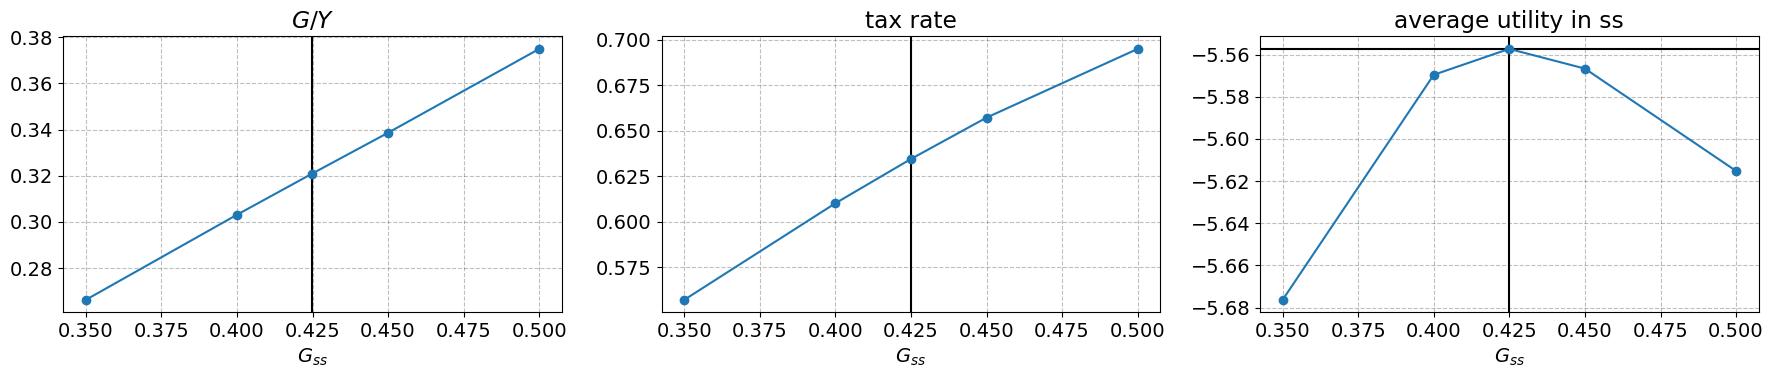

In [26]:
fig = plt.figure(figsize=(18,6/1.5),dpi=100)

ax = fig.add_subplot(1,3,1)
ax.set_title('$G/Y$')
ax.axvline(G_max_U_hh,color='black')
ax.plot(Gs,Y_G,'-o')
ax.set_xlabel('$G_{ss}$')

ax = fig.add_subplot(1,3,2)
ax.set_title('tax rate')
ax.axvline(G_max_U_hh,color='black')
ax.plot(Gs,tau,'-o')
ax.set_xlabel('$G_{ss}$')

ax = fig.add_subplot(1,3,3)
ax.set_title('average utility in ss')
ax.axvline(G_max_U_hh,color='black')
ax.axhline(-max_U_hh,color='black')
ax.plot(Gs,U_hh,'-o')
ax.set_xlabel('$G_{ss}$')

fig.tight_layout()
fig.savefig('figs/optimal_G_ss.png',dpi=100)

In [27]:
ss.G = G_max_U_hh
model.find_ss(do_print=True)

starting at KL=3.8624

 message: The solution converged.
 success: True
  status: 1
     fun: 2.215202311032402
       x: [ 3.862e+00]
    nfev: 11
    fjac: [[-1.000e+00]]
       r: [ 6.021e+04]
     qtf: [-2.215e+00]

steady state found in 7.4 secs
ss.K =  3.409
ss.A_hh =  1.186
ss.Y =  1.324
ss.r =  0.016
ss.w =  1.050
ss.G =  0.425
ss.LG =  0.425
ss.LY =  0.883
ss.tau =  0.634
ss.chi =  0.000
ss.clearing_A = 2.22e+00
ss.clearing_L = 0.00e+00
ss.clearing_Y = 3.66e-02


In [28]:
v_hh_ss = model.v_ss()
print(f'{v_hh_ss:.4f}')

-138.9320


In [29]:
# def target(x):
#     chi = x
#     ss.chi = chi
#     # ss.G = ss.LG*ss.w + ss.chi - ss.tau*ss.w*ss.L_hh
#     model.find_ss(do_print=False)
#     return -ss.U_hh

# res = optimize.minimize_scalar(target,bounds=(-0.25,0.1),method='bounded',options={'disp':3})
# chi_max_U_hh = res.x
# max_U_hh = res.fun

In [30]:
def target(x, model):
    G,chi = x
    ss.G = G
    ss.chi = chi
    print(f"guessing on G = {G:.4f}, chi = {chi:.4f}, which yields: {model.ss.U_hh = :8.3f}")
    model.find_ss(do_print=False)
    return -ss.U_hh

bounds = [(0.4, 0.45),(-0.25, 0.1)]  # Bounds for G and chi
initial_guess = [0.425, -0.22]  # initial guess for G and chi
opts = {'disp': 3, 'eps': 1e-3}  # Adjust eps for minimum step size
res = optimize.minimize(target,initial_guess,bounds=bounds,method='L-BFGS-B',args=(model,),options=opts,tol=0.01)
G_max_U_hh = res.x[0]
chi_max_U_hh = res.x[1]
max_U_hh = -res.fun

guessing on G = 0.4250, chi = -0.2200, which yields: model.ss.U_hh =   -5.557
guessing on G = 0.4260, chi = -0.2200, which yields: model.ss.U_hh =   -5.507
guessing on G = 0.4250, chi = -0.2190, which yields: model.ss.U_hh =   -5.481
guessing on G = 0.4500, chi = -0.2391, which yields: model.ss.U_hh =   -5.507
guessing on G = 0.4490, chi = -0.2391, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4500, chi = -0.2381, which yields: model.ss.U_hh =   -5.476
guessing on G = 0.4376, chi = -0.2296, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4386, chi = -0.2296, which yields: model.ss.U_hh =   -5.502
guessing on G = 0.4376, chi = -0.2286, which yields: model.ss.U_hh =   -5.476
guessing on G = 0.4438, chi = -0.2344, which yields: model.ss.U_hh =   -5.502
guessing on G = 0.4448, chi = -0.2344, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4438, chi = -0.2334, which yields: model.ss.U_hh =   -5.476
guessing on G = 0.4469, chi = -0.2368, which yields: model.ss.U_

In [31]:
print(G_max_U_hh, chi_max_U_hh, max_U_hh)

0.44605774534969167 -0.23611213023400102 -5.475877687697288


In [32]:
chis = sorted([-0.35,-0.3,-0.25,-0.15]+[chi_max_U_hh])

G_Y = np.zeros(len(chis))
K = np.zeros(len(chis))
U_hh = np.zeros(len(chis))

for i,chi in enumerate(chis):
    
    model_ = model.copy()
    model_.ss.chi = chi
    model_.find_ss(do_print=False)

    print(f'{model_.ss.chi = :8.5f}')
    # print(f'{model_.ss.G = :8.3f}')
    print(f'{model_.ss.G/model_.ss.Y = :8.3f}')
    print(f'{model_.ss.U_hh = :12.8f}\n')

    G_Y[i] = model_.ss.G/model_.ss.Y
    K[i] = model_.ss.K
    U_hh[i] = model_.ss.U_hh

model_.ss.chi = -0.35000
model_.ss.G/model_.ss.Y =    0.299
model_.ss.U_hh =  -5.50249210

model_.ss.chi = -0.30000
model_.ss.G/model_.ss.Y =    0.302
model_.ss.U_hh =  -5.50062253

model_.ss.chi = -0.25000
model_.ss.G/model_.ss.Y =    0.306
model_.ss.U_hh =  -5.50042337

model_.ss.chi = -0.23611
model_.ss.G/model_.ss.Y =    0.307
model_.ss.U_hh =  -5.50074694

model_.ss.chi = -0.15000
model_.ss.G/model_.ss.Y =    0.315
model_.ss.U_hh =  -5.50796067



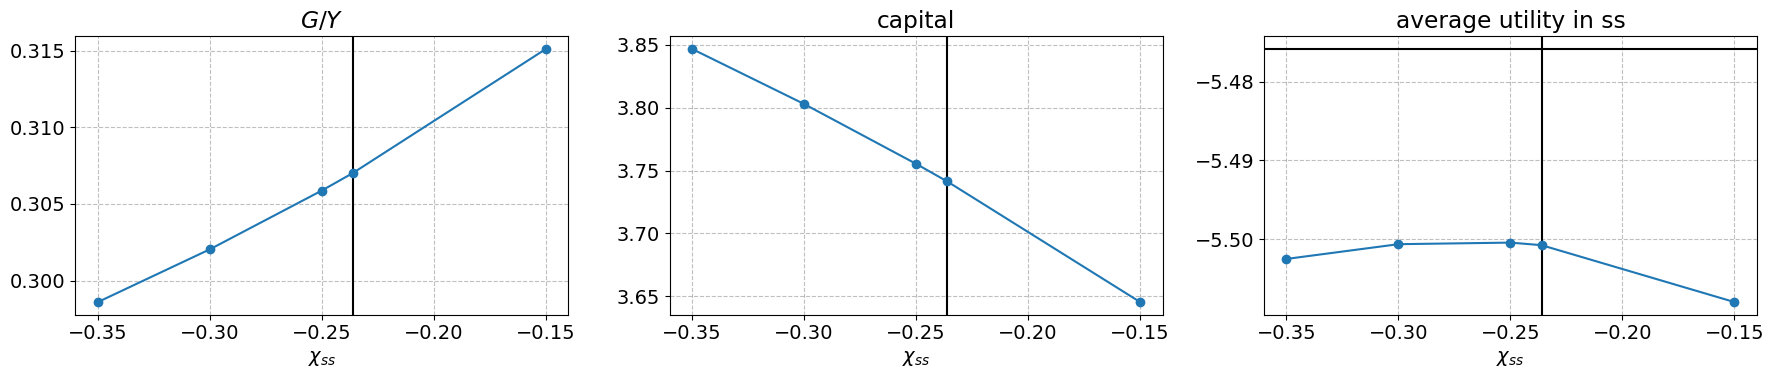

In [33]:
fig = plt.figure(figsize=(18,6/1.5),dpi=100)

ax = fig.add_subplot(1,3,1)
ax.set_title('$G/Y$')
ax.axvline(chi_max_U_hh,color='black')
ax.plot(chis,G_Y,'-o')
ax.set_xlabel('$\\chi_{ss}$')

ax = fig.add_subplot(1,3,2)
ax.set_title('capital')
ax.axvline(chi_max_U_hh,color='black')
ax.plot(chis,K,'-o')
ax.set_xlabel('$\\chi_{ss}$')

ax = fig.add_subplot(1,3,3)
ax.set_title('average utility in ss')
ax.axvline(chi_max_U_hh,color='black')
ax.axhline(max_U_hh,color='black')
ax.plot(chis,U_hh,'-o')
ax.set_xlabel('$\\chi_{ss}$')

fig.tight_layout()
fig.savefig('figs/optimal_chi_ss.png',dpi=100)

In [34]:
ss.chi = chi_max_U_hh
ss.G = G_max_U_hh

model.find_ss(do_print=True)

starting at KL=3.8624

 message: The solution converged.
 success: True
  status: 1
     fun: 1.1635197320694362
       x: [ 3.862e+00]
    nfev: 12
    fjac: [[-1.000e+00]]
       r: [-2.084e+03]
     qtf: [-1.164e+00]

steady state found in 12.1 secs
ss.K =  3.741
ss.A_hh =  2.577
ss.Y =  1.453
ss.r =  0.016
ss.w =  1.050
ss.G =  0.446
ss.LG =  0.446
ss.LY =  0.969
ss.tau =  0.457
ss.chi = -0.236
ss.clearing_A = 1.16e+00
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.92e-02


In [35]:
v_hh_ss = model.v_ss()
print(f'{v_hh_ss:.4f}')

-137.5187


Increased TFP for private sector to $\Gamma_Y = 1.1$

In [36]:
par.Gamma_Y = 1.1
bounds = [(0.4, 0.45),(-0.25, 0.1)]  # Bounds for G and chi
initial_guess = [0.425, -0.22]  # initial guess for G and chi
opts = {'disp': 3, 'eps': 1e-3}  # Adjust eps for minimum step size
res = optimize.minimize(target,initial_guess,bounds=bounds,method='L-BFGS-B',args=(model,),options=opts,tol=0.01)
G_max_U_hh_gamma = res.x[0]
chi_max_U_hh_gamma = res.x[1]
max_U_hh = -res.fun

guessing on G = 0.4250, chi = -0.2200, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4260, chi = -0.2200, which yields: model.ss.U_hh =   -5.198
guessing on G = 0.4250, chi = -0.2190, which yields: model.ss.U_hh =   -5.175
guessing on G = 0.4500, chi = -0.2441, which yields: model.ss.U_hh =   -5.198
guessing on G = 0.4490, chi = -0.2441, which yields: model.ss.U_hh =   -5.178
guessing on G = 0.4500, chi = -0.2431, which yields: model.ss.U_hh =   -5.157
guessing on G = 0.4378, chi = -0.2324, which yields: model.ss.U_hh =   -5.178
guessing on G = 0.4388, chi = -0.2324, which yields: model.ss.U_hh =   -5.186
guessing on G = 0.4378, chi = -0.2314, which yields: model.ss.U_hh =   -5.163
guessing on G = 0.4441, chi = -0.2384, which yields: model.ss.U_hh =   -5.186
guessing on G = 0.4451, chi = -0.2384, which yields: model.ss.U_hh =   -5.181
guessing on G = 0.4441, chi = -0.2374, which yields: model.ss.U_hh =   -5.159
guessing on G = 0.4471, chi = -0.2413, which yields: model.ss.U_

In [37]:
model_gamma = model.copy()
model_gamma.ss.chi = chi_max_U_hh_gamma
model_gamma.ss.G = G_max_U_hh_gamma
model_gamma.find_ss(do_print=True)

starting at KL=4.4258

 message: The solution converged.
 success: True
  status: 1
     fun: 1.217628463541784
       x: [ 4.426e+00]
    nfev: 13
    fjac: [[-1.000e+00]]
       r: [ 2.066e+03]
     qtf: [-1.218e+00]

steady state found in 9.9 secs
ss.K =  3.952
ss.A_hh =  2.734
ss.Y =  1.535
ss.r =  0.016
ss.w =  1.203
ss.G =  0.449
ss.LG =  0.449
ss.LY =  0.893
ss.tau =  0.462
ss.chi = -0.243
ss.clearing_A = 1.22e+00
ss.clearing_L = 0.00e+00
ss.clearing_Y = 2.01e-02


In [38]:
v_hh_ss = model_gamma.v_ss()
print(f'{v_hh_ss:.4f}')
print(f'G/Y = {model_gamma.ss.G/model_gamma.ss.Y = :8.3f}')

-129.4748
G/Y = model_gamma.ss.G/model_gamma.ss.Y =    0.292


## 5. <a id='toc9_'></a>[Find transition path](#toc0_)

Jacobians

In [75]:
# model_gamma.compute_jacs(do_print=True)
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for S               in 1.2 secs
curly_Y and curly_D calculated for chi             in 1.1 secs
curly_Y and curly_D calculated for r               in 1.4 secs
curly_Y and curly_D calculated for tau             in 1.6 secs
curly_Y and curly_D calculated for wt              in 1.1 secs
curly_E calculated in 0.7 secs
builiding blocks combined in 0.7 secs
household Jacobian computed in 8.0 secs

full Jacobians:
full Jacobian to unknowns computed in 9.2 secs [in evaluate_blocks(): 0.7 secs]
full Jacobian to shocks computed in 1.8 secs [in evaluate_blocks(): 0.5 secs]


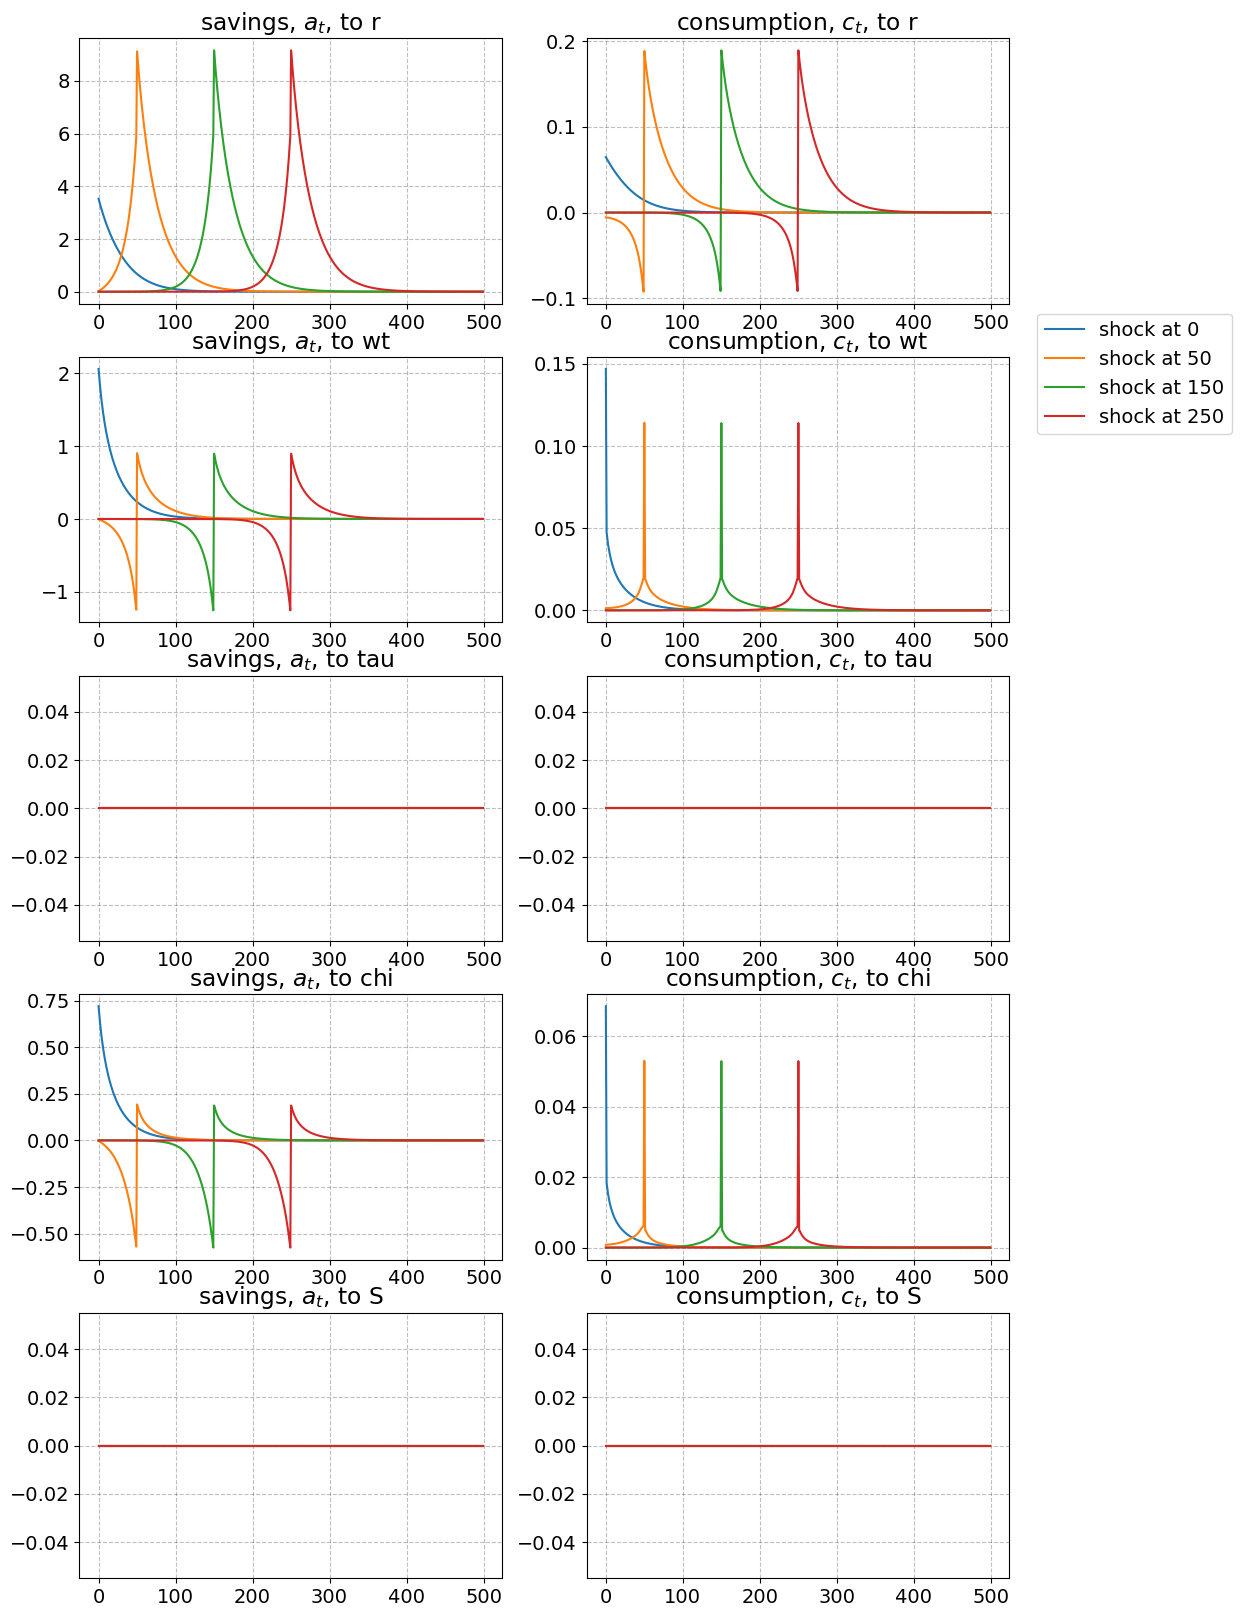

In [40]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

In [76]:
# model_gamma.find_transition_path(shocks=[],ini=model.ss.__dict__,do_print=True)
model.find_transition_path(shocks=[],ini=model_gamma.ss.__dict__,do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 9.20e-01
   9.20e-01 in clearing_A
   8.77e-02 in clearing_L
 it =   1 -> max. abs. error = 4.54e-02
   4.54e-02 in clearing_A
   4.11e-02 in clearing_L
 it =   2 -> max. abs. error = 1.31e-02
   1.31e-02 in clearing_A
   5.04e-03 in clearing_L
 it =   3 -> max. abs. error = 1.27e-03
   1.27e-03 in clearing_A
   4.23e-04 in clearing_L
 it =   4 -> max. abs. error = 9.02e-05
   9.02e-05 in clearing_A
   3.28e-05 in clearing_L
 it =   5 -> max. abs. error = 4.85e-06
   4.85e-06 in clearing_A
   2.42e-06 in clearing_L
 it =   6 -> max. abs. error = 1.02e-07
   1.02e-07 in clearing_A
   6.69e-08 in clearing_L
 it =   7 -> max. abs. error = 4.24e-09
   4.24e-09 in clearing_A
   2.65e-09 in clearing_L
 it =   8 -> max. abs. error = 1.59e-10
   1.59e-10 in clearing_A
   1.42e-10 in clearing_L
 it =   9 -> max. abs. error = 6.51e-12
   6.51e-12 in clearing_A
   1.58e-12 in clearing_L
K: terminal value is   3.72732279, but ss value is 

In [77]:
path = model.path

### shocks ###


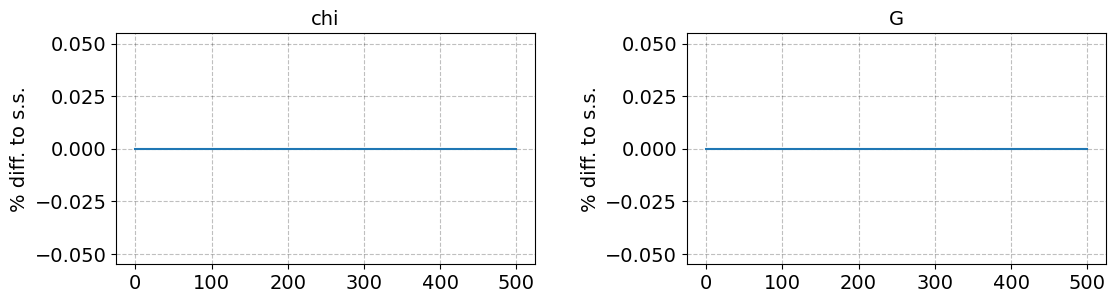


### varnames ###


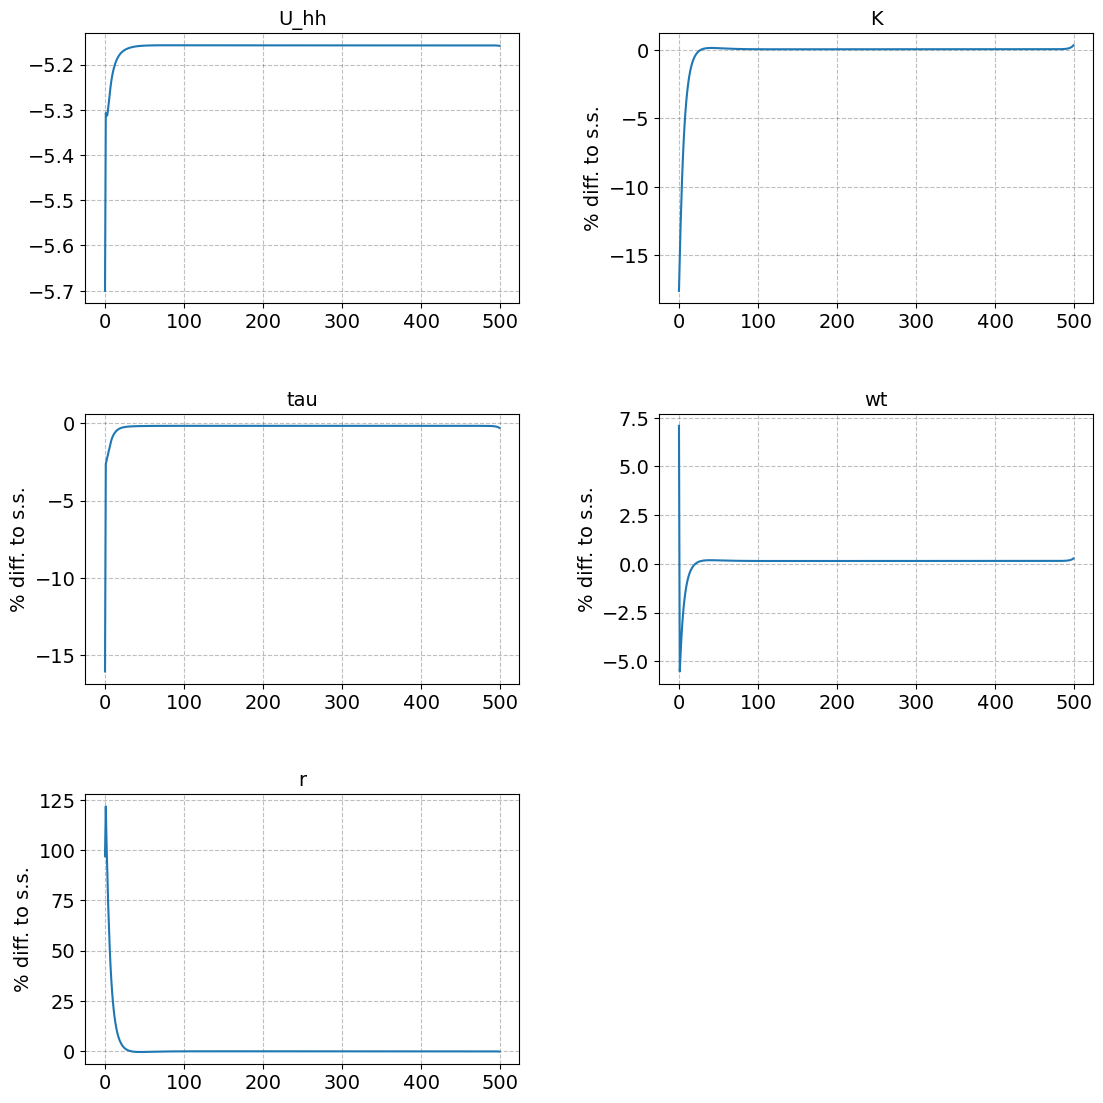


### tagets ###


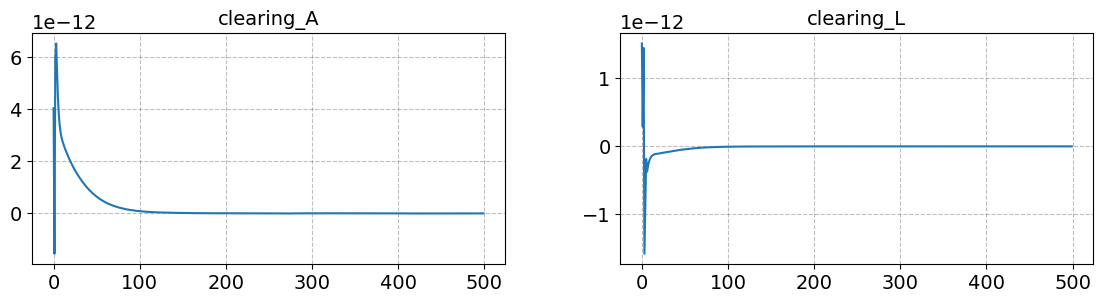

In [79]:
model.show_IRFs(varnames=['U_hh','K','tau','wt','r'],lvl_value=['U_hh'],ncols=2)

In [81]:
v_hh_ss = model.v_ss()
v_hh = model.v_path()
print(f'{v_hh_ss = :.5f}')
print(f'{v_hh = :.5f}')

v_hh_ss = -128.94041
v_hh = -130.64375


In [47]:
def utility_of_G_and_chi(x, model):
    G, chi = x

    model.ss.G = G
    model.ss.chi = chi
    # print(f"guessing on G = {G:.4f}, chi = {chi:.4f}, which yields: {model.ss.U_hh = :8.3f}")
    # Find the steady state and return the negative of utility
    model.find_ss(do_print=False)
    return -model.ss.U_hh

# Define bounds for G and chi based on previously found optimal values
G_bounds = (G_max_U_hh, G_max_U_hh_gamma)  
chi_bounds = (chi_max_U_hh_gamma, chi_max_U_hh)

# Optimize G and chi
def optimize_G_and_chi(model, initial_guess=(G_max_U_hh, chi_max_U_hh)):
    res = optimize.minimize(utility_of_G_and_chi, initial_guess, bounds=[G_bounds, chi_bounds],
                            method='L-BFGS-B', args=(model,), options={'disp': True, 'eps': 1e-3})
    return res.x[0], res.x[1], -res.fun

# Initialize a dictionary to store optimal values at each gamma step
optimal_values = {}

# Loop over gamma steps
for gamma_step in np.linspace(1.0, 1.1, 10):
    # Update the model's TFP parameter
    model.par.Gamma_Y = gamma_step
    
    # Optimize G and chi for the current gamma
    optimal_G, optimal_chi, utility_optimal = optimize_G_and_chi(model)
    
    # Store the optimal values and utility for this step
    optimal_values[gamma_step] = (optimal_G, optimal_chi, utility_optimal)
    
    # Update the model with the new optimal values
    model.ss.G = optimal_G
    model.ss.chi = optimal_chi
    
    # Continue the simulation to the next step
    # Assume find_transition_path is defined in your model
    model.find_transition_path(shocks=[], ini=model.ss.__dict__, do_print=False)

guessing on G = 0.4461, chi = -0.2361, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4471, chi = -0.2361, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4461, chi = -0.2371, which yields: model.ss.U_hh =   -5.476
guessing on G = 0.4486, chi = -0.2427, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4476, chi = -0.2427, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4486, chi = -0.2417, which yields: model.ss.U_hh =   -5.476
guessing on G = 0.4473, chi = -0.2394, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4483, chi = -0.2394, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4473, chi = -0.2384, which yields: model.ss.U_hh =   -5.476
guessing on G = 0.4463, chi = -0.2368, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4473, chi = -0.2368, which yields: model.ss.U_hh =   -5.476
guessing on G = 0.4463, chi = -0.2378, which yields: model.ss.U_hh =   -5.501
guessing on G = 0.4462, chi = -0.2365, which yields: model.ss.U_

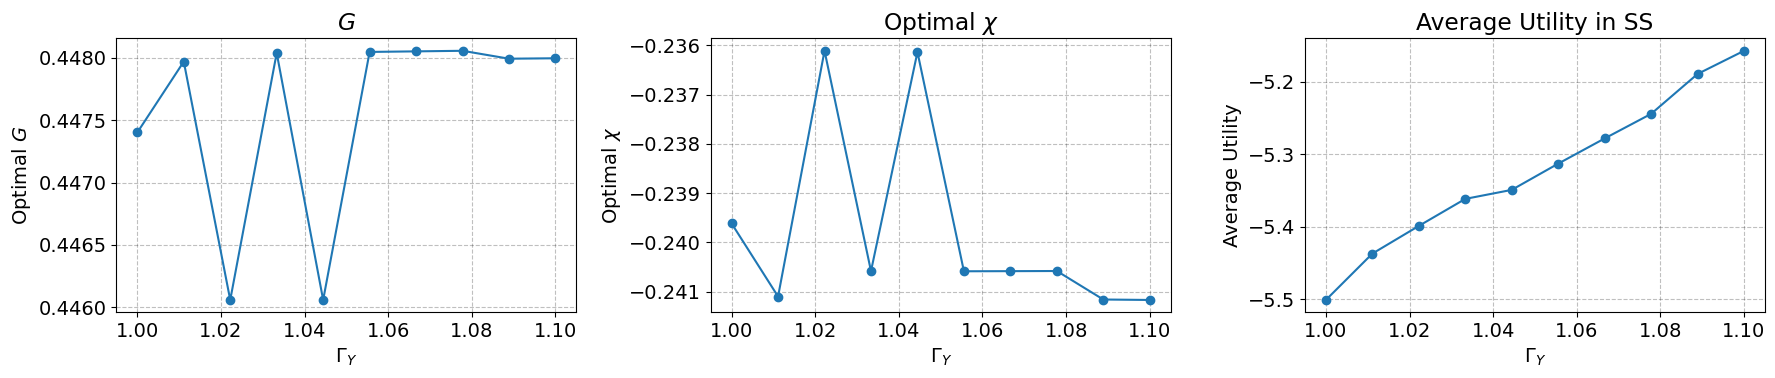

In [53]:
gamma_steps = np.linspace(1.0, 1.1, 10)

G_values = [optimal_values[gamma_step][0] for gamma_step in gamma_steps]
chi_values = [optimal_values[gamma_step][1] for gamma_step in gamma_steps]
utility_values = [optimal_values[gamma_step][2] for gamma_step in gamma_steps]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18,6/1.5))

# G/Y plot
axes[0].plot(gamma_steps, G_values, '-o')
axes[0].set_title('$G$')
axes[0].set_xlabel('$\Gamma_Y$')
axes[0].set_ylabel('Optimal $G$')

# chi plot
axes[1].plot(gamma_steps, chi_values, '-o')
axes[1].set_title('Optimal $\chi$')
axes[1].set_xlabel('$\Gamma_Y$')
axes[1].set_ylabel('Optimal $\chi$')

# Utility plot
axes[2].plot(gamma_steps, utility_values, '-o')
axes[2].set_title('Average Utility in SS')
axes[2].set_xlabel('$\Gamma_Y$')
axes[2].set_ylabel('Average Utility')

fig.tight_layout()
plt.show()

# Save the figure if needed
fig.savefig('figs/optimal_values_transition.png', dpi=100)

In [34]:
for add in [-0.01,0.01]:

    # a. initial steady state
    model_chi_alt = model.copy()
    model.ss.chi = chi_max_U_hh_gamma + add
    model_chi_alt.find_ss()

    # b. transition to new steady state 
    model.find_transition_path(shocks=[],ini=model_chi_alt.ss.__dict__,do_print=False)

    # b. change in expected discounted utility
    def print_v(model,model_chi_alt):

        # steady state    
        v_hh_ss = model_chi_alt.v_ss()
        assert np.isclose(v_hh_ss,1/(1-par.beta)*model_chi_alt.ss.U_hh)

        # allong transition path
        v_hh = model.v_path()

        # difference
        print(f'chi {chi_max_U_hh+add:.3} -> {chi_max_U_hh:.3f}: {v_hh-v_hh_ss = :8.5f}')

    print_v(model,model_chi_alt)

K: terminal value is   3.85683607, but ss value is   3.71773149
LY: terminal value is   0.90075673, but ss value is   0.87831089
rK: terminal value is   0.11977277, but ss value is   0.12019132
w: terminal value is   1.18885513, but ss value is   1.18707908
Y: terminal value is   1.52981323, but ss value is   1.48946355
A: terminal value is   3.85683607, but ss value is   3.71773149
r: terminal value is   0.01977277, but ss value is   0.02019132
tau: terminal value is   0.45455853, but ss value is   0.46941720
wt: terminal value is   0.64845089, but ss value is   0.62984374
A_hh: terminal value is   3.85683607, but ss value is   3.71701112
C_hh: terminal value is   0.67300189, but ss value is   0.66909073
ELL_hh: terminal value is   1.49611635, but ss value is   1.47533146
L_hh: terminal value is   1.34934184, but ss value is   1.32689601
INC_hh: terminal value is   0.69804924, but ss value is   0.66909074
U_hh: terminal value is  -5.17243826, but ss value is  -5.15739170
I: terminal v

In [35]:
model_gradual = model.copy()

In [36]:
shocks = {'dchi':np.zeros(par.T)}
shocks['dchi'][:50] = np.linspace(-0.04,0.0,50)

In [37]:
model_gradual.find_transition_path(shocks=shocks,ini=model_gamma.ss.__dict__,do_print=False)
print(f'gradual phase in:')
print_v(model_gradual,model_chi_alt)

K: terminal value is   3.60107493, but ss value is   3.71773149
LY: terminal value is   0.85935505, but ss value is   0.87831089
rK: terminal value is   0.12055084, but ss value is   0.12019132
w: terminal value is   1.18556053, but ss value is   1.18707908
Y: terminal value is   1.45545348, but ss value is   1.48946355
A: terminal value is   3.60107493, but ss value is   3.71773149
r: terminal value is   0.02055084, but ss value is   0.02019132
tau: terminal value is   0.48219514, but ss value is   0.46941720
wt: terminal value is   0.61388901, but ss value is   0.62984374
A_hh: terminal value is   3.60107493, but ss value is   3.71701112
C_hh: terminal value is   0.66560007, but ss value is   0.66909073
ELL_hh: terminal value is   1.45852033, but ss value is   1.47533146
L_hh: terminal value is   1.30794017, but ss value is   1.32689601
INC_hh: terminal value is   0.64466762, but ss value is   0.66909074
U_hh: terminal value is  -5.14834228, but ss value is  -5.15739170
I: terminal v

In [38]:
jump = ss.chi*0.01
rho = 0.95
dchi = jump*rho**np.arange(par.T)

In [39]:
model.find_transition_path(shocks={'dchi':dchi},do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.08e-01
   1.08e-01 in clearing_A
   5.77e-03 in clearing_L
 it =   1 -> max. abs. error = 3.85e-04
   3.68e-04 in clearing_A
   3.85e-04 in clearing_L
 it =   2 -> max. abs. error = 1.61e-05
   1.61e-05 in clearing_A
   1.24e-05 in clearing_L
 it =   3 -> max. abs. error = 1.93e-07
   1.93e-07 in clearing_A
   1.58e-07 in clearing_L
 it =   4 -> max. abs. error = 3.32e-09
   2.94e-09 in clearing_A
   3.32e-09 in clearing_L
 it =   5 -> max. abs. error = 2.83e-11
   2.83e-11 in clearing_A
   2.46e-11 in clearing_L
K: terminal value is   3.60107493, but ss value is   3.71773149
LY: terminal value is   0.85935505, but ss value is   0.87831089
rK: terminal value is   0.12055084, but ss value is   0.12019132
w: terminal value is   1.18556053, but ss value is   1.18707908
Y: terminal value is   1.45545348, but ss value is   1.48946355
A: terminal value is   3.60107493, but ss value is   3.71773149
r: terminal value is   0.02055084

### shocks ###


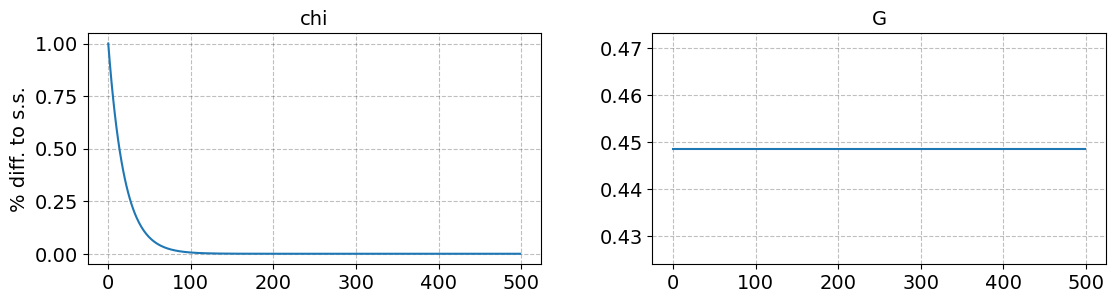


### varnames ###


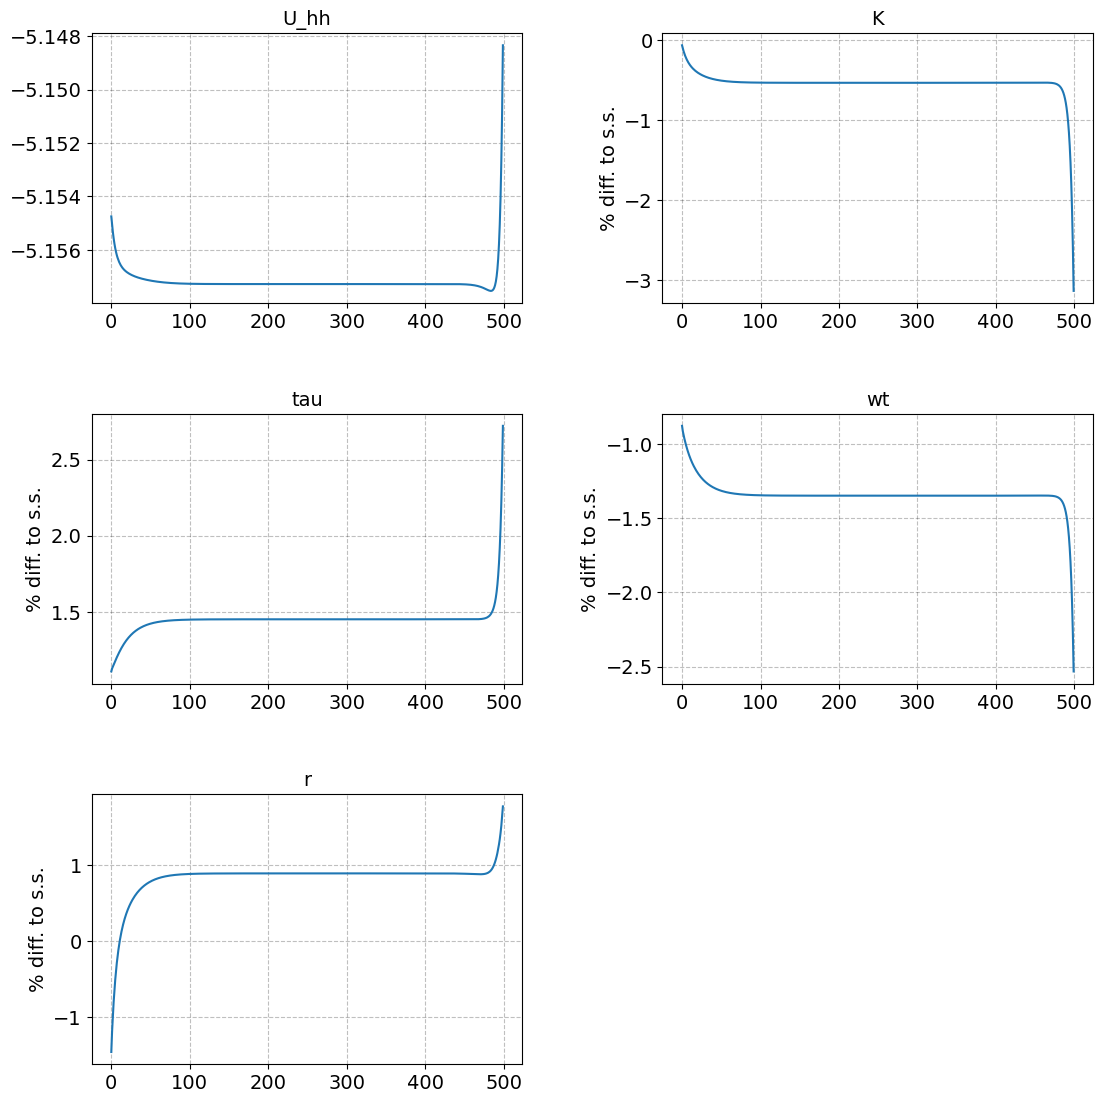


### tagets ###


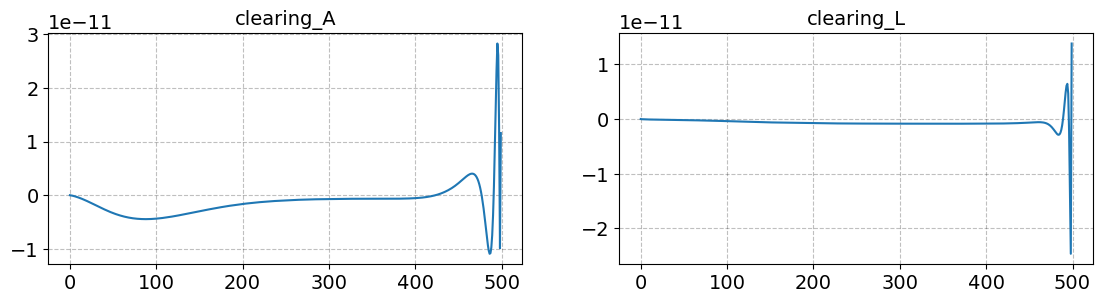

In [40]:
model.show_IRFs(varnames=['U_hh','K','tau','wt','r'],lvl_value=['U_hh','G'],ncols=2)

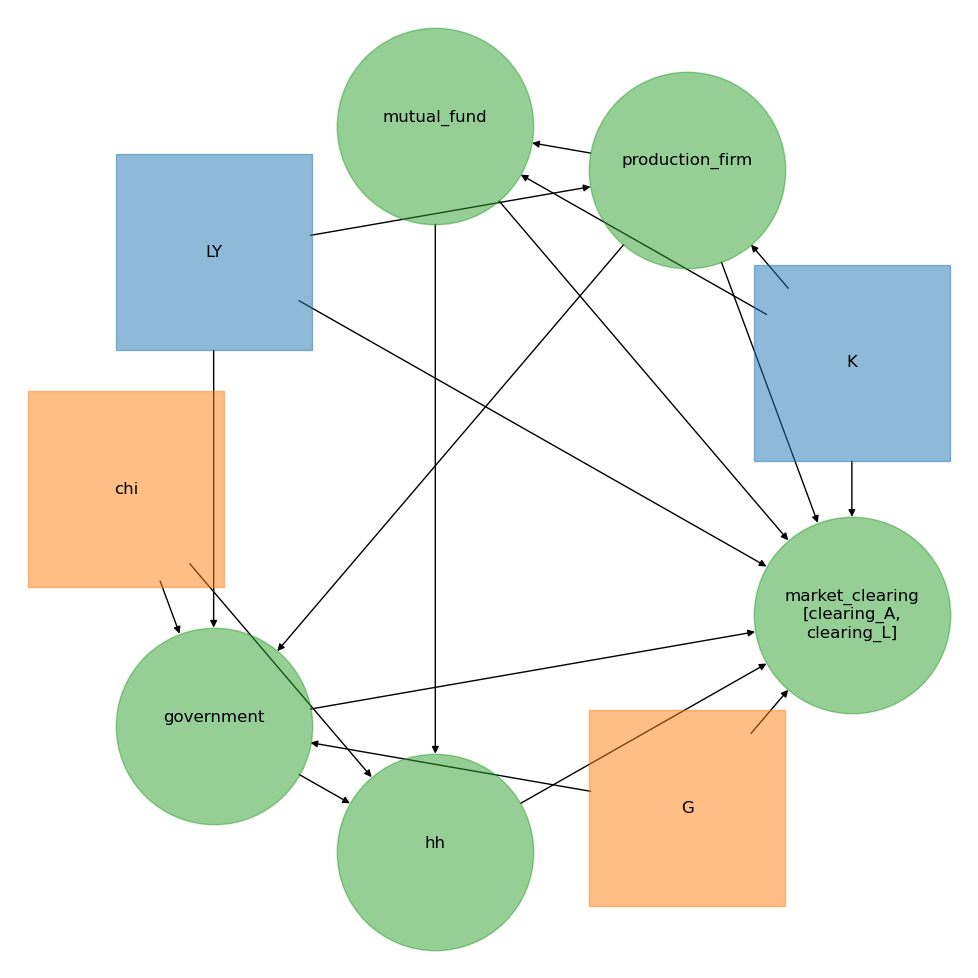

In [41]:
model.draw_DAG(filename='DAG.png')

## 6. <a id='toc6_'></a>[Policy functions](#toc0_)

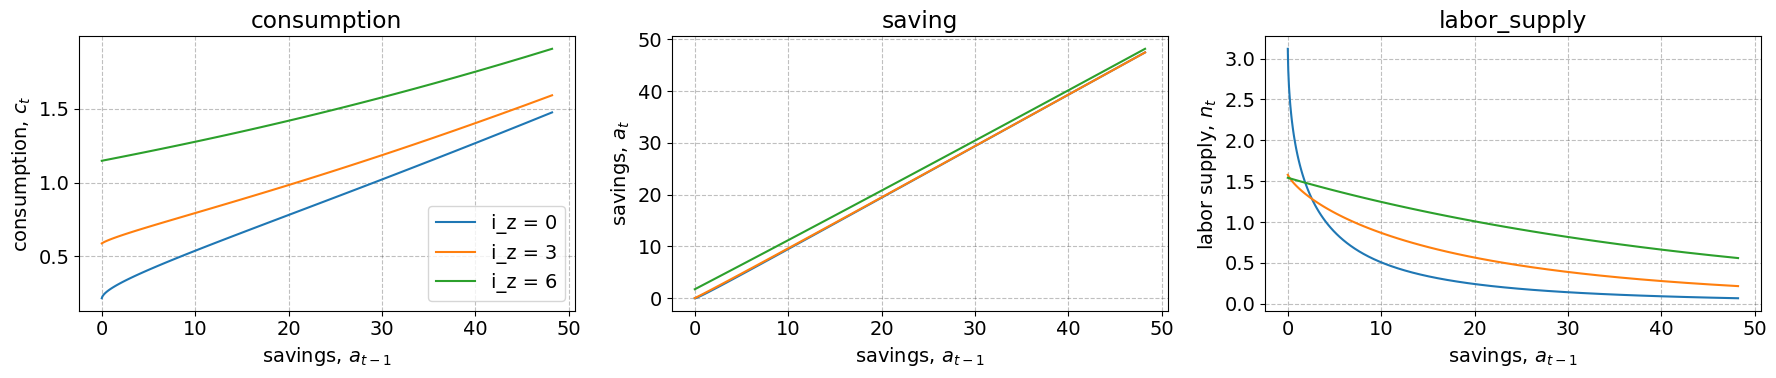

In [42]:
i_fix = 0

fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 50

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()
plt.show()